# Variational autoencoder
- Probablistic autoencoders: the outputs are partly determined by chance, even after training
- generative autoencoders: it can generate new instances that look like they were sampled from the training set.
- performs variational Bayesian inference
- Instead of directly producing a latent representation for a given input, the encoder produces a mean and a standard deviation Then the actual latent representation is sampled from a Gaussian distribution with the generated mean and standard deviation. 
- After training a variaonal autoencoder, you can very easily generate a new instance by sampling a random numbers from the gaussian distribution and decode it!
- The cost function consists of two parts:
    1. reconstruction loss that pushes the autoencoder to reproduce its inputs
    2. latent loss that pushes the autoencoder to have coding that looks as though they were sampled from a simple gaussian distribution

## Importing dependencies


In [27]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Layer, Input, Dense, Flatten, Reshape
import matplotlib.pyplot as plt

print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")

tensorflow version: 2.2.0
keras version: 2.3.0-tf


## Exploratory data analysis & data preprocesin

In [0]:
#load data
(X_train, y_train),(X_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [0]:
X_train.shape
X_train_rescaled = X_train /255
X_test_rescaled = X_test / 255

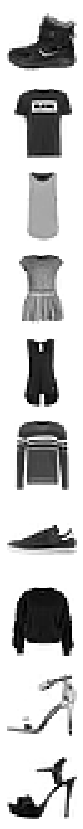

In [28]:
#visualize a few
number_of_digits = 10
num_examples = 10
plt.rcParams['image.cmap'] = "binary"
plt.rcParams['figure.figsize'] = [15,15]
fig, axes_list = plt.subplots(10)
for i in range(num_examples):
        axes_list[i].imshow(X_train_rescaled[i],interpolation="nearest")
        axes_list[i].axis("off")

## Custom layer to sample coding

In [0]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs #mean and log(variance) -- using log(var) is numerically more stable.
        return K.random_normal(tf.shape(log_var)) + K.exp(log_var/2) + mean #sample from N(mean, exp(log_var/2))        

In [0]:
# create a model using functional API because the model is not entirely sequential
codings_size = 10
image_size = X_train.shape[1:]

#create encoder part of the variational autoencoder
inputs = keras.layers.Input(shape=image_size)
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z) #mean
codings_log_var = keras.layers.Dense(codings_size)(z) #log(var)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

#create decoder latent representation size = 10
decoder_inputs = Input(shape=[codings_size])
x = Dense(100, activation="selu")(decoder_inputs)
x = Dense(150, activation="selu")(x)
x = Dense(28*28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28,28])(x)
variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [0]:
#let's build the variational model
_, _, codings = variational_encoder(inputs) #give the size of inputs
reconstructions = variational_decoder(codings)
variational_ae = keras.Model(inputs=[inputs], outputs=[reconstructions])

In [0]:
#let's add the latent loss and reconstruction loss
latent_loss = -0.5 * K.sum( 1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),axis=-1)
variational_ae.add_loss(K.mean(latent_loss)/784)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop")

## Train

In [72]:
variational_ae.fit(X_train_rescaled,X_train_rescaled, epochs=50, batch_size=128, validation_data=(X_test_rescaled,X_test_rescaled))

Epoch 1/50
469/469 [==============================] - 4s 7ms/step - loss: 0.3871 - val_loss: 0.3552
Epoch 2/50
469/469 [==============================] - 3s 6ms/step - loss: 0.3515 - val_loss: 0.3480
Epoch 3/50
469/469 [==============================] - 3s 6ms/step - loss: 0.3446 - val_loss: 0.3456
Epoch 4/50
469/469 [==============================] - 3s 6ms/step - loss: 0.3414 - val_loss: 0.3427
Epoch 5/50
469/469 [==============================] - 3s 6ms/step - loss: 0.3391 - val_loss: 0.3434
Epoch 6/50
469/469 [==============================] - 3s 6ms/step - loss: 0.3376 - val_loss: 0.3392
Epoch 7/50
469/469 [==============================] - 3s 7ms/step - loss: 0.3364 - val_loss: 0.3385
Epoch 8/50
469/469 [==============================] - 3s 7ms/step - loss: 0.3355 - val_loss: 0.3384
Epoch 9/50
469/469 [==============================] - 3s 6ms/step - loss: 0.3346 - val_loss: 0.3360
Epoch 10/50
469/469 [==============================] - 3s 6ms/step - loss: 0.3341 - val_loss: 0.3394

## Generate Fashion MNIST Images

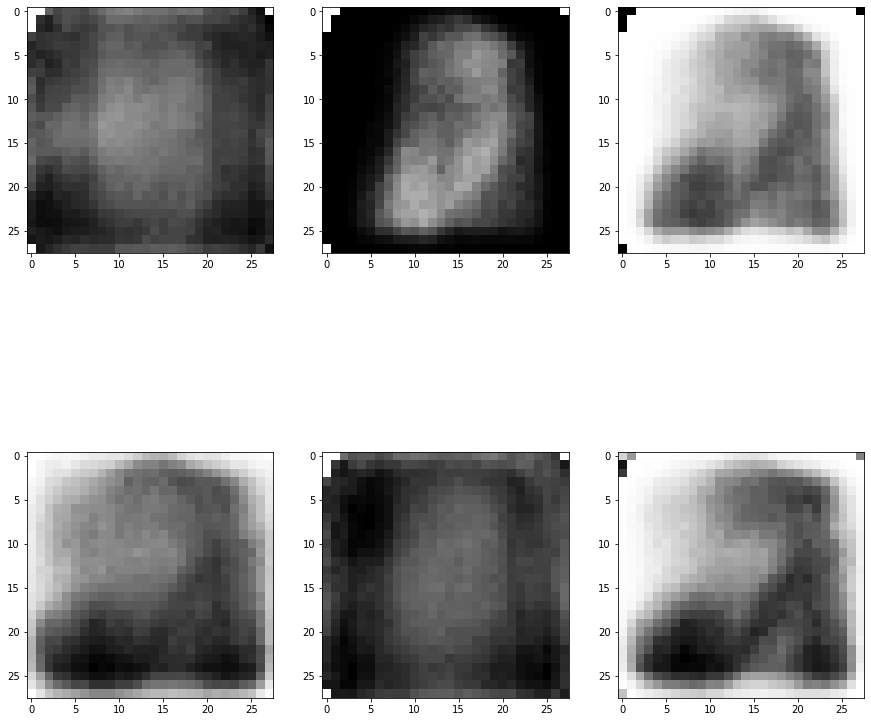

In [55]:
codings = tf.random.normal(shape=[6,codings_size])
images = variational_decoder(codings).numpy()
_, axes = plt.subplots(2,3)
for index, image in enumerate(images):
    axes[index//3, index%3].imshow(image,interpolation="nearest")
